In [78]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

import pickle

from pathlib import Path

In [2]:
DATA_PATH = Path('/media/maciej/Volume/data/002_pd')

In [16]:
paths = list(DATA_PATH.glob('*.data'))

In [39]:
with open(paths[0], 'rb') as file:
    data = pd.read_pickle(file)
    df = data[0]
    signals = data[1]

In [41]:
df.groupby('inst_id')['row_id'].count().value_counts()

row_id
4    909
1     97
3     68
2     32
Name: count, dtype: int64

In [81]:
def onset_detection_fun(signal_ar, #save=False,
                        window_length=500, window_step=5, sample_start_search=500, sample_end_search=2000,
                        onset_threshold=0.1, number_extracted_samples=625, energy_gap=250):

    # Cycle over all the available events
    for x in range(len(signal_ar)):
        # Extract a signal at every iteration
        signal = signal_ar[x].astype(np.int64)
        # Extract the pulse samples in the selected interval for onset detection (between sample_start_search and sample_end_search)
        signal_range = signal[sample_start_search:sample_end_search]
        # Extract the pulse samples in an interval which is required for HOS moments calculation
        signal_range_hos = signal[(sample_start_search - window_length + 1):sample_end_search]
        # Define empty lists storing, for each event, the statistic moments values computed on all the the time windows
        s1 = []
        s2 = []
        s6 = []
        # High order statistic moments calculation for each time window
        for xx in range(int(len(signal_range) / window_step)):
            # Compute the time window limits as function of the iterative step
            begin_window = int(xx * window_step)
            end_window = int(xx * window_step + window_length)
            # Extract the waveform contained in the moving windows for a specific iterative step
            wave = signal_range_hos[begin_window:end_window]
            # First statistic moment (mean) calculation
            s1.append(np.mean(wave))
            # Second statistic moment (variance) calculation
            s2.append(np.sum((wave - s1[xx]) ** 2) / (window_length - 1))
            # Sixth statistic (S6) moment calculation
            s6.append(np.sum((wave - s1[xx]) ** 6) / ((window_length - 1) * (s2[xx] ** 3)) - 15)
        # Calculation of the derivative of the sixth statistic moment (dS6)
        ds6 = np.gradient(s6)
        # Compute the threshold for pulse onset detection (equal to a given percentage of the maximum value of ds6)
        threshold = onset_threshold * np.nanmax(ds6)
        # Identify all the samples that are above the threshold
        onset_index_ds6 = np.where(abs(ds6) >= threshold)[0].astype(np.int16)
        # Define an empty array for storage of the sign of each identified sample
        onset_sign = np.empty(len(onset_index_ds6))
        # Iterate over the identified samples to find crossings
        # For crossing the product of (sample_value_n - threshold)*(sample_value_(n-1) - threshold) is negative
        for xx in range(len(onset_index_ds6)):
            onset_sign[xx] = (ds6[onset_index_ds6[xx]] - threshold) * (ds6[onset_index_ds6[xx] - 1] - threshold)
        # For crossing the sample is passed, else the 0 value is passed (or the sample_start_search value)
        onset_indices = (np.where(np.sign(onset_sign) == -1, onset_index_ds6, 0) * window_step) + sample_start_search
        # Indexes with value of 0 (or the sample_start_search value) are cut
        onset_indices = onset_indices[np.where(onset_indices > sample_start_search)]
        # Definition of the empty SNR list
        onset_ratios = []
        # Iterate over the crossings to calculate the SNR of each crossing
        for xx in range(len(onset_indices)):
            potential_onset = onset_indices[xx]
            pre_onset = np.sum(signal[(potential_onset - energy_gap): potential_onset] ** 2)
            post_onset = np.sum(signal[potential_onset: (potential_onset + energy_gap)] ** 2)
            SN_ratio = post_onset / pre_onset
            onset_ratios.append(SN_ratio)
        # The crossing with the highest SNR is identified as the onset
        onset_index = onset_indices[np.argmax(np.array(onset_ratios))]

        # Define the number of samples to be extracted after pulse onset (set in code options)
        num_samples = number_extracted_samples
        # Extraction of first num_samples samples after pulse onset
        waveform_from_onset = signal[(onset_index):(onset_index + num_samples)]
        # Add the extracted waveform and the onset index to the previously defined lists
        signal_extracted.append(waveform_from_onset)
        onset_picked.append(onset_index)



    # if save:    # If save is True the feature file is saved
    #     with open('./features/onset_' + case, 'wb') as file:
    #         pickle.dump(signal_extracted, file, protocol=pickle.HIGHEST_PROTOCOL)
    #     print('Features saved.')

    return signal_extracted, onset_picked, ds6

In [92]:
# Params
window_length=500
window_step=5

begin_sample = 500
end_sample = 2000
search_interval = slice(begin_sample, end_sample)

onset_threshold=0.1
number_extracted_samples=625
energy_gap=250

In [159]:
class OnsetDetection():
    def __init__(self, window = 500, step = 10, interval = (500, 2000), threshold=0.1) -> None:
        self.window = window
        self.step = step

        assert len(interval) == 2, 'The length of interval should be 2'
        self.begin, self.end = interval
        self.range = (self.end - self.begin) // self.step
        self.threshold = threshold

    def get_s6(self, signal: np.array) -> np.array:

        signal = np.asarray(signal)

        signal_slice = slice((self.begin - self.window + 1), self.end)
        signal_range = signal[signal_slice]

        # Define empty lists storing
        signal_s6_out = np.zeros(self.range)

        # High order statistic moments calculation for each time window
        for i in range(self.range):

            # Compute the time window limits as function of the iterative step
            begin_window = int(i * self.step)
            end_window = int(i * self.step + self.window)

            # Extract the waveform contained in the moving windows for a specific iterative step
            wave = signal_range[begin_window:end_window]
            signal_s1 = np.mean(wave)
            signal_s2 = np.var(wave)

            # Sixth statistic (S6) moment calculation
            signal_s6 = np.sum((wave - signal_s1) ** 6) / ((self.window - 1) * (signal_s2 ** 3))
            signal_s6_out[i] = (signal_s6 - 15)
        
        return signal_s6_out
    

    def _first_positive_index(self, x):
        # Ensure the input is a numpy array
        x = np.asarray(x)
        
        # Use boolean indexing to find where the values are positive
        positive_indices = np.where(x > 0)[0]
        
        # Check if there is any positive value
        if positive_indices.size == 0:
            raise ValueError('No positive values in the array')
        
        # Return the index of the first positive value
        return positive_indices[0]
    
    def _grad_and_level(self, x):

        # Ensure the input is a numpy array
        x = np.asarray(x)

        x_grad = np.abs(np.gradient(x))
        
        # Normalize
        x_grad /= np.max(x_grad) 

        # Level with threshold
        x_grad -= self.threshold

        return x_grad
        


In [160]:
od = OnsetDetection()
test = od.get_s6(signal=signals[0])

In [162]:
grad = od._grad_and_level(test)
id = od._first_positive_index(grad)

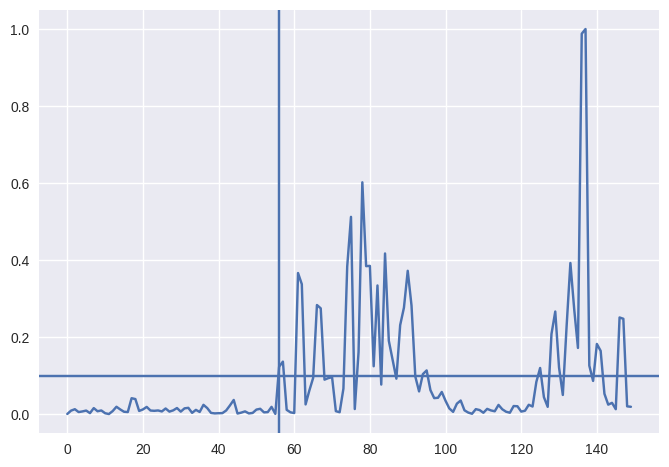

In [163]:
grad = np.abs(np.gradient(test)) 
plt.plot(grad / np.max(grad))
plt.axhline(0.1)
plt.axvline(id)